#**Data Spaces**
###**Matteo Stoisa**

###*IMPORT LIBRERIE E DATASET:*

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns; 
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

drive.mount('/content/gdrive', force_remount=True)
dataset_path = "/content/gdrive/My Drive/Colab Notebooks/the-spotify-hit-predictor-dataset/dataset-of-10s.csv"

Mounted at /content/gdrive


###*PULIZIA FEATURE:*


In [ ]:
whole_dataset = pd.read_csv(dataset_path, delimiter=",") 

artists = whole_dataset.loc[:, 'artist']
withFeaturing = []
for artist in artists:
  if "Featuring" in artist:
    withFeaturing.append(1)
  else:
    withFeaturing.append(0)
whole_dataset['featuring'] = withFeaturing

whole_attributes = list(whole_dataset.columns.values)
secondary_attributes = ['track', 'artist', 'uri']
primary_attributes = []
for attribute in whole_attributes:
  if attribute not in secondary_attributes:
    primary_attributes.append(attribute)

dataset = whole_dataset.drop(columns = secondary_attributes)
dataset_labels = dataset.loc[:, 'target']
dataset = dataset.drop(columns='target')
primary_attributes.remove('target')
secondary_dataset = whole_dataset.drop(columns = primary_attributes)
secondary_dataset = secondary_dataset.drop(columns='target')

print("- whole_dataset: {}\n  whole_attributes: {}".format(whole_dataset.shape, whole_dataset.columns.values))
print("- dataset: {}\n  primary_attributes: {}".format(dataset.shape, dataset.columns.values))
print("- secondary_dataset: {}\n  secondary_attributes: {}".format(secondary_dataset.shape, secondary_dataset.columns.values))
print("- dataset_labels: {}".format(dataset_labels.shape))

- whole_dataset: (6398, 20)
  whole_attributes: ['track' 'artist' 'uri' 'danceability' 'energy' 'key' 'loudness' 'mode'
 'speechiness' 'acousticness' 'instrumentalness' 'liveness' 'valence'
 'tempo' 'duration_ms' 'time_signature' 'chorus_hit' 'sections' 'target'
 'featuring']
- dataset: (6398, 16)
  primary_attributes: ['danceability' 'energy' 'key' 'loudness' 'mode' 'speechiness'
 'acousticness' 'instrumentalness' 'liveness' 'valence' 'tempo'
 'duration_ms' 'time_signature' 'chorus_hit' 'sections' 'featuring']
- secondary_dataset: (6398, 3)
  secondary_attributes: ['track' 'artist' 'uri']
- dataset_labels: (6398,)


###*ESEMPIO ENTRY:* 


In [ ]:
print("DATASET PRIMARIO:\n{}\n{}".format(dataset.iloc[[297]].to_string(), dataset.iloc[[298]].to_string()))
print("\nDATASET SECONDARIO:\n{}\n{}".format(secondary_dataset.iloc[[297]].to_string(), secondary_dataset.iloc[[298]].to_string()))
print("\nTARGET:\n{}\n{}".format(dataset_labels.iloc[[297]].to_string(), dataset_labels.iloc[[298]].to_string()))

DATASET PRIMARIO:
     danceability  energy  key  loudness  mode  speechiness  acousticness  instrumentalness  liveness  valence   tempo  duration_ms  time_signature  chorus_hit  sections  featuring
297         0.571   0.568    1    -3.827     0       0.0703         0.218            0.0021     0.512    0.109  86.986       547733               4    39.40648        17          1
     danceability  energy  key  loudness  mode  speechiness  acousticness  instrumentalness  liveness  valence   tempo  duration_ms  time_signature  chorus_hit  sections  featuring
298          0.48   0.837   11    -5.495     0         0.24         0.103               0.0     0.128    0.652  91.916       246079               4    33.81769        12          0

DATASET SECONDARIO:
       track                        artist                                   uri
297  Runaway  Kanye West Featuring Pusha T  spotify:track:3DK6m7It6Pw857FcQftMds
          track       artist                                   uri
298  El 

###*NORMALIZZAZIONE E SPLIT:*


In [ ]:
scaler = preprocessing.MinMaxScaler()
attributes_to_scale = ['danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit', 'sections']
dataset[attributes_to_scale] = scaler.fit_transform(dataset[attributes_to_scale])
whole_dataset[attributes_to_scale] = scaler.fit_transform(whole_dataset[attributes_to_scale])

x_train, x_test, y_train, y_test = train_test_split(dataset, dataset_labels, test_size=0.2, stratify=dataset_labels, random_state=15)

print(dataset.iloc[[297]].to_string())
print(dataset.iloc[[298]].to_string())

     danceability   energy       key  loudness  mode  speechiness  acousticness  instrumentalness  liveness  valence     tempo  duration_ms  time_signature  chorus_hit  sections  featuring
297      0.553766  0.56846  0.090909  0.920913     0     0.051205      0.218876          0.002111  0.513105  0.11168  0.277475     0.303858             0.8    0.184872  0.174419          1
     danceability    energy  key  loudness  mode  speechiness  acousticness  instrumentalness  liveness   valence     tempo  duration_ms  time_signature  chorus_hit  sections  featuring
298      0.454724  0.837797  1.0  0.885047     0     0.232994      0.103414               0.0  0.115301  0.668033  0.306204     0.126867             0.8    0.158653  0.116279          0


###*MATRICE DI CORRELAZIONE:*

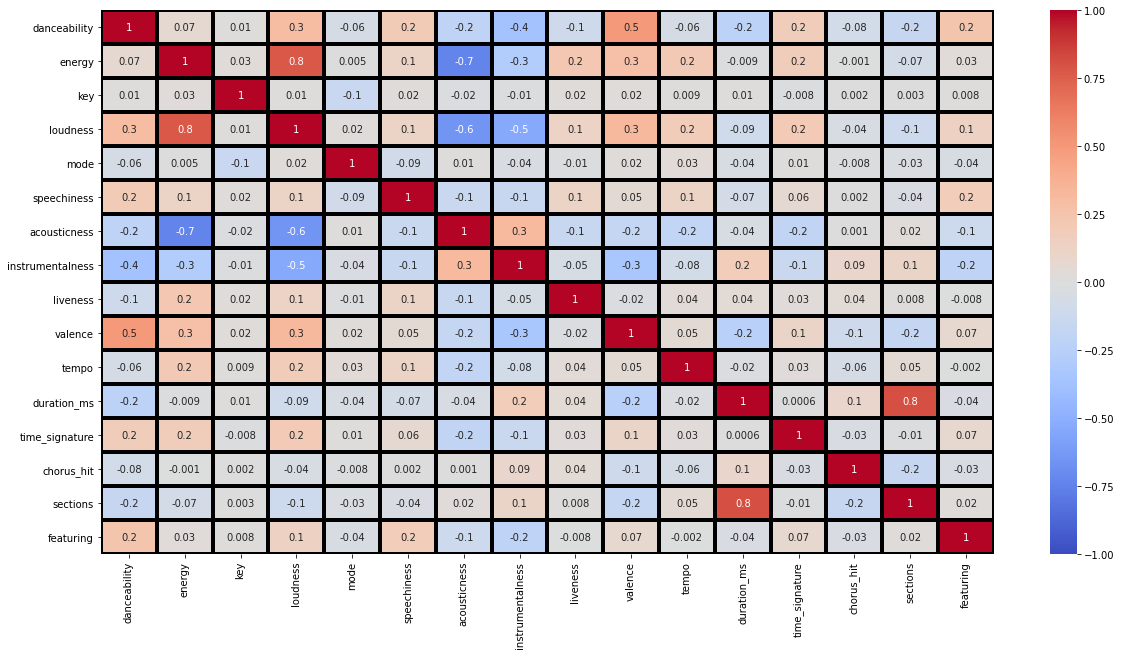

POSITIVE CORRELATION MEAN:  0.1179760439309974  (52.5 %)
NEGATIVE CORRELATION MEAN: -0.12625219521592493 (47.5 %)


In [ ]:
correlation_matrix = dataset.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black')
plt.show()
positive_count = 0
negative_count = 0
positive_sum = 0
negative_sum = 0
for i in range(1, len(correlation_matrix)):
  for j in range(i):
    if correlation_matrix.iloc[i, j] > 0:
      positive_count += 1
      positive_sum += correlation_matrix.iloc[i, j]
    else:
      negative_count += 1
      negative_sum += correlation_matrix.iloc[i, j]

print("POSITIVE CORRELATION MEAN:  {}  ({} %)".format(positive_sum / positive_count, (positive_count / (positive_count + negative_count)) * 100))
print("NEGATIVE CORRELATION MEAN: {} ({} %)".format(negative_sum / negative_count, (negative_count / (positive_count + negative_count)) * 100))

###*CORRELAZIONE CON IL TARGET:*

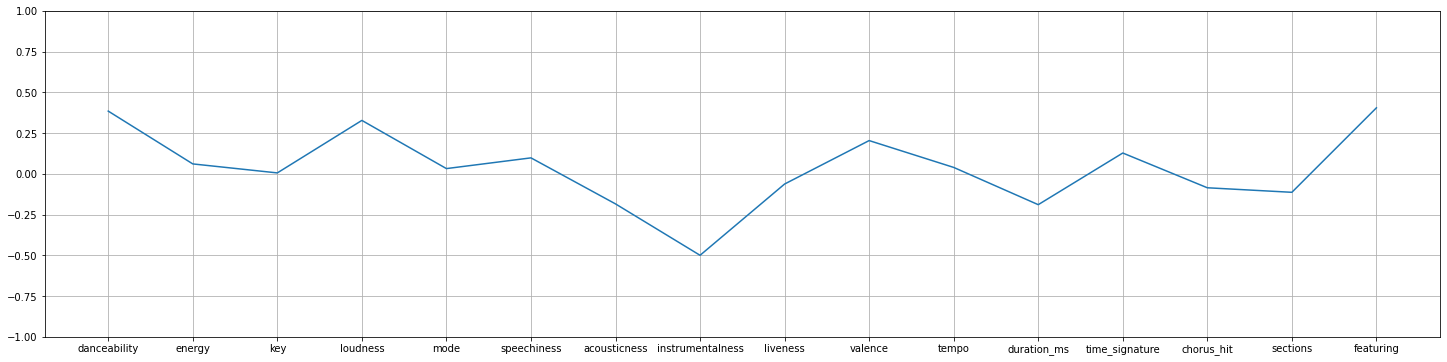

POSITIVE CORRELATION MEAN:  0.16831462505991987  (62.5 %)
NEGATIVE CORRELATION MEAN: -0.18914825072033462 (37.5 %)


In [ ]:
correlation_target = whole_dataset.corr().loc[primary_attributes , 'target']
plt.figure(figsize=(25, 6))
plt.plot(correlation_target)
plt.ylim(-1, 1)
plt.grid(True)
plt.show()

positive_count = 0
negative_count = 0
positive_sum = 0
negative_sum = 0
for num in correlation_target:
  if num > 0:
    positive_count += 1
    positive_sum += num
  else:
    negative_count += 1
    negative_sum += num

print("POSITIVE CORRELATION MEAN:  {}  ({} %)".format(positive_sum / positive_count, (positive_count / len(primary_attributes)) * 100))
print("NEGATIVE CORRELATION MEAN: {} ({} %)".format(negative_sum / negative_count, (negative_count / len(primary_attributes)) * 100))

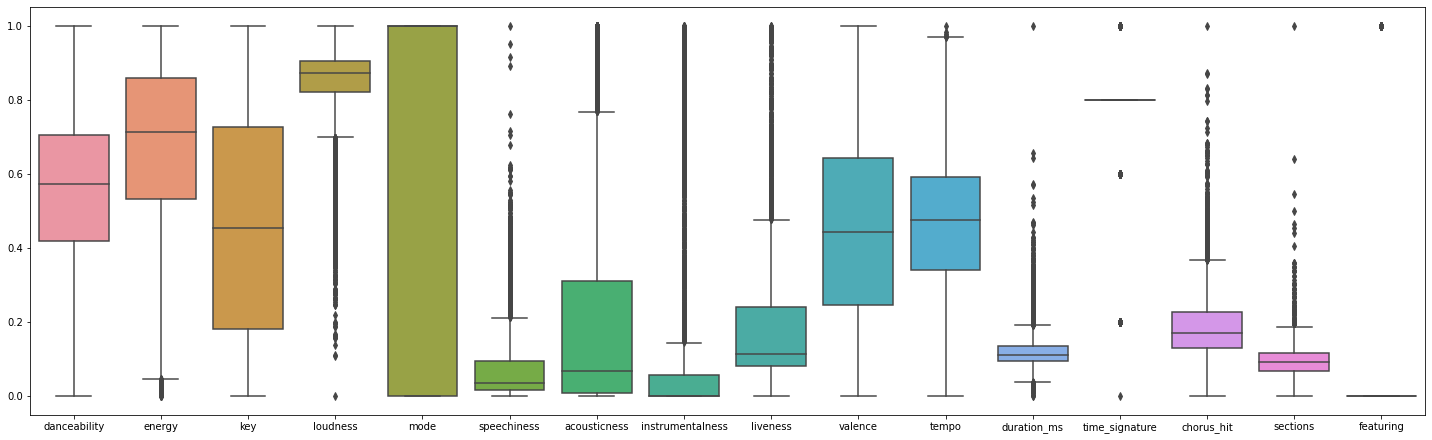

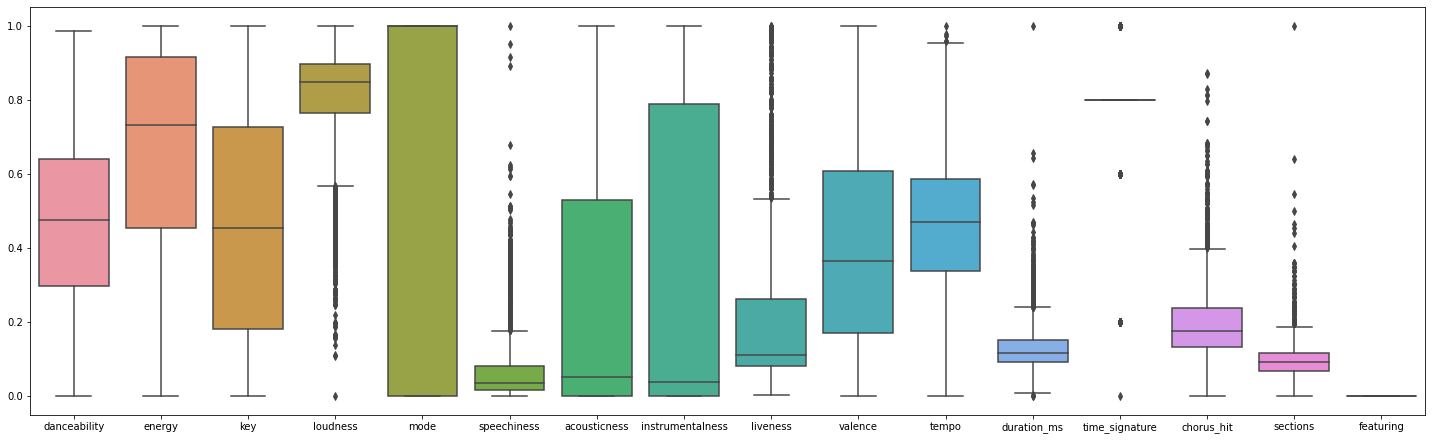

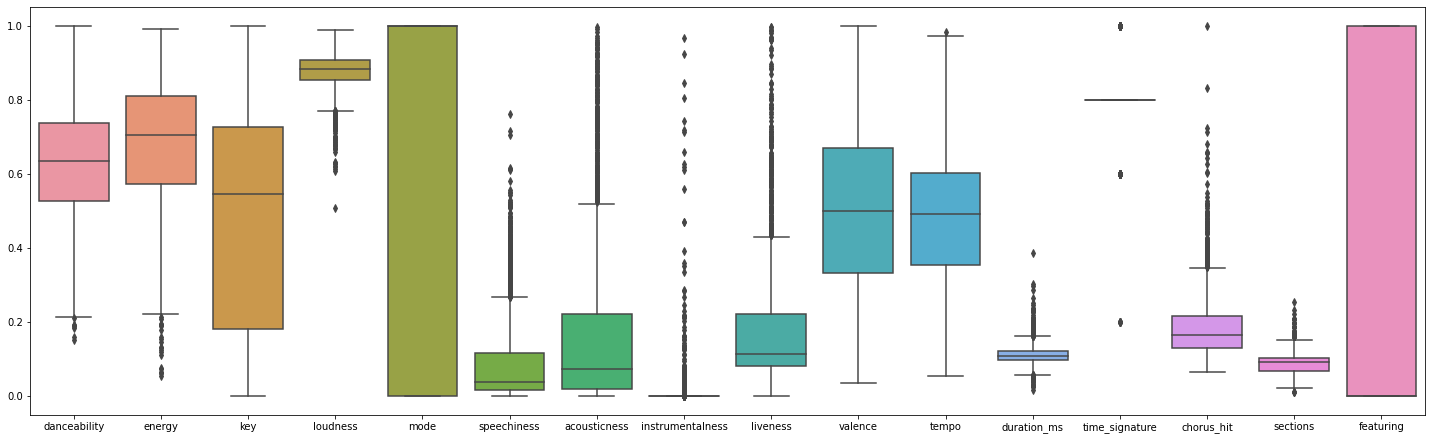

In [ ]:
whole_dataset_0 = whole_dataset.loc[whole_dataset['target'] == 0]
whole_dataset_1 = whole_dataset.loc[whole_dataset['target'] == 1]

fig = plt.figure(figsize=(25, 7.5))
ax = sns.boxplot(data=whole_dataset[primary_attributes])
plt.show()

fig = plt.figure(figsize=(25, 7.5))
ax = sns.boxplot(data=whole_dataset_0[primary_attributes])
plt.show()

fig = plt.figure(figsize=(25, 7.5))
ax = sns.boxplot(data=whole_dataset_1[primary_attributes])
plt.show()

In [ ]:
to_remove = pd.DataFrame()
for feature in primary_attributes:
  to_remove[feature] = whole_dataset[feature].between(whole_dataset[feature].quantile(0.05), whole_dataset[feature].quantile(0.95))
print(to_remove)

for feature in primary_attributes:
  print(feature, Counter(to_remove[feature]))

to_drop = []
vector = []
for i in range(0, 6398):
  vector.append(True)
  for feature in primary_attributes:
    vector[i] = vector[i] and to_remove[feature][i]
  if not vector[i]:
    to_drop.append(i) 

print(vector)
print(Counter(vector))

dropped = dataset.drop(to_drop)
droppedy = dataset_labels.drop(to_drop)

print(dropped)

      danceability  energy   key  ...  chorus_hit  sections  featuring
0             True    True  True  ...        True      True       True
1             True    True  True  ...        True      True       True
2             True    True  True  ...        True      True       True
3             True    True  True  ...        True      True       True
4             True    True  True  ...        True      True       True
...            ...     ...   ...  ...         ...       ...        ...
6393         False    True  True  ...        True      True       True
6394         False    True  True  ...        True      True       True
6395          True    True  True  ...        True      True       True
6396          True    True  True  ...        True      True       True
6397         False   False  True  ...        True      True       True

[6398 rows x 16 columns]
danceability Counter({True: 5763, False: 635})
energy Counter({True: 5760, False: 638})
key Counter({True: 6398})
loudness

###*REGRESSIONE LINEARE:*

In [ ]:
model = LogisticRegression(max_iter=200)
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['none', 'l1', 'l2', 'elasticnet']
c_values = [0.001, 0.01, 1, 10, 100]

grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=5, 
                           scoring='accuracy',
                           error_score=0)
grid_result = grid_search.fit(x_train, y_train)

print("Best validation: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Test score: %f" % metrics.accuracy_score(grid_result.best_estimator_.predict(x_test), y_test))

KeyboardInterrupt: ignored

In [ ]:
model = LogisticRegression(max_iter=200)
solvers = ['lbfgs']
penalty = ['l2']
c_values = range(1, 100, 1)

grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=5, 
                           scoring='accuracy',
                           error_score=0)
grid_result = grid_search.fit(x_train, y_train)

print("Best validation: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Test score: %f" % metrics.accuracy_score(grid_result.best_estimator_.predict(x_test), y_test))

Best validation: 0.821416 using {'C': 13, 'penalty': 'l2', 'solver': 'lbfgs'}
Test score: 0.808594


In [ ]:
model = LogisticRegression(max_iter=200)
solvers = ['lbfgs']
penalty = ['l2']
c_values = np.arange(9, 11, 0.075)

grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=5, 
                           scoring='accuracy',
                           error_score=0)
grid_result = grid_search.fit(x_train, y_train)

print("Best validation: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Test score: %f" % metrics.accuracy_score(grid_result.best_estimator_.predict(x_test), y_test))

Best validation: 0.820440 using {'C': 10.799999999999983, 'penalty': 'l2', 'solver': 'lbfgs'}
Test score: 0.810156


In [ ]:
model = LogisticRegression(max_iter=200)
solvers = ['lbfgs']
penalty = ['l2']
c_values = np.arange(9.5, 11, 0.025)

grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=5, 
                           scoring='accuracy',
                           error_score=0)
grid_result = grid_search.fit(x_train, y_train)

print("Best validation: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Test score: %f" % metrics.accuracy_score(grid_result.best_estimator_.predict(x_test), y_test))

Best validation: 0.820440 using {'C': 10.675000000000017, 'penalty': 'l2', 'solver': 'lbfgs'}
Test score: 0.809375


###*KNN:*

In [ ]:
model = KNeighborsClassifier()
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']

grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=5, 
                           scoring='accuracy',
                           error_score=0)
grid_result = grid_search.fit(x_train, y_train)

print("Best validation: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Test score: %f" % metrics.accuracy_score(grid_result.best_estimator_.predict(x_test), y_test))

Best validation: 0.805004 using {'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'distance'}
Test score: 0.792188


###*GAUSSIAN NAIVE BAYES:*

In [ ]:
model = GaussianNB()

var_smoothing = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
grid = dict(var_smoothing=var_smoothing)
grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=5, 
                           scoring='accuracy',
                           error_score=0)
grid_result = grid_search.fit(x_train, y_train)

print("Best validation: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Test score: %f" % metrics.accuracy_score(grid_result.best_estimator_.predict(x_test), y_test))

Best validation: 0.795823 using {'var_smoothing': 0.0001}
Test score: 0.789844


###*RANDOM FOREST:*

In [ ]:
model = RandomForestClassifier()

n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']

grid = dict(n_estimators=n_estimators,max_features=max_features)
grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=5, 
                           scoring='accuracy',
                           error_score=0)
grid_result = grid_search.fit(x_train, y_train)

print("Best validation: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Test score: %f" % metrics.accuracy_score(grid_result.best_estimator_.predict(x_test), y_test))

Best validation: 0.859126 using {'max_features': 'log2', 'n_estimators': 1000}
Test score: 0.855469


###*SUPPORT VECTOR MACHINE:*

In [ ]:
model = SVC()

kernel = ['poly', 'rbf', 'sigmoid']
C = [1, 10, 50, 100]
gamma = ['scale']

grid = dict(kernel=kernel,C=C,gamma=gamma)
grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, cv=5, 
                           scoring='accuracy',
                           error_score=0)
grid_result = grid_search.fit(x_train, y_train)

print("Best validation: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Test score: %f" % metrics.accuracy_score(grid_result.best_estimator_.predict(x_test), y_test))

Best validation: 0.840764 using {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
Test score: 0.825781


###*PRINCIPAL COMPONENT ANALISYS:*

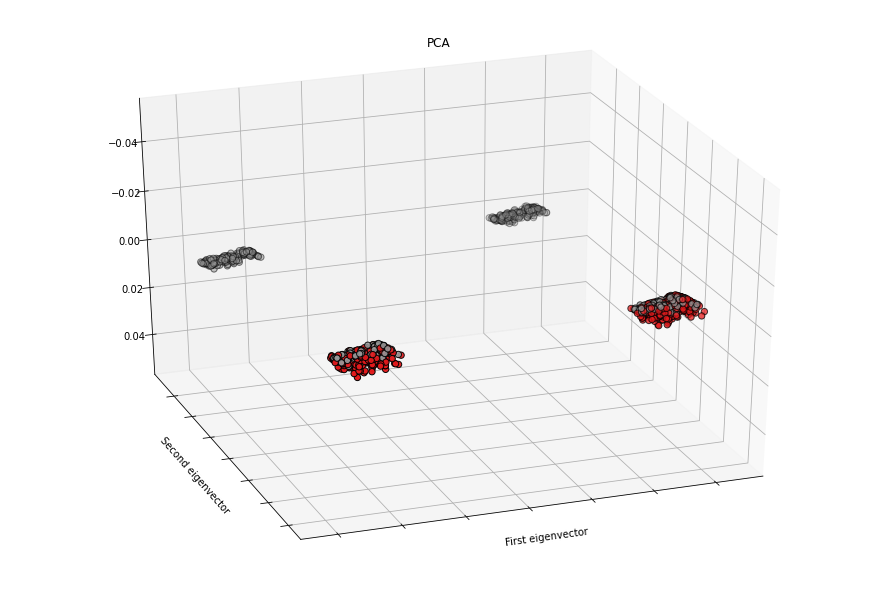

In [ ]:
fig = plt.figure(1, figsize=(12, 8))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=2).fit_transform(dropped)
ax.scatter(X_reduced[:, 0], 
          X_reduced[:, 1], 
          c=droppedy,
          cmap=plt.cm.Set1, 
          edgecolor='k', 
          s=40)
ax.set_title("PCA")
ax.set_xlabel("First eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("Second eigenvector")
ax.w_yaxis.set_ticklabels([])

plt.show()

5118


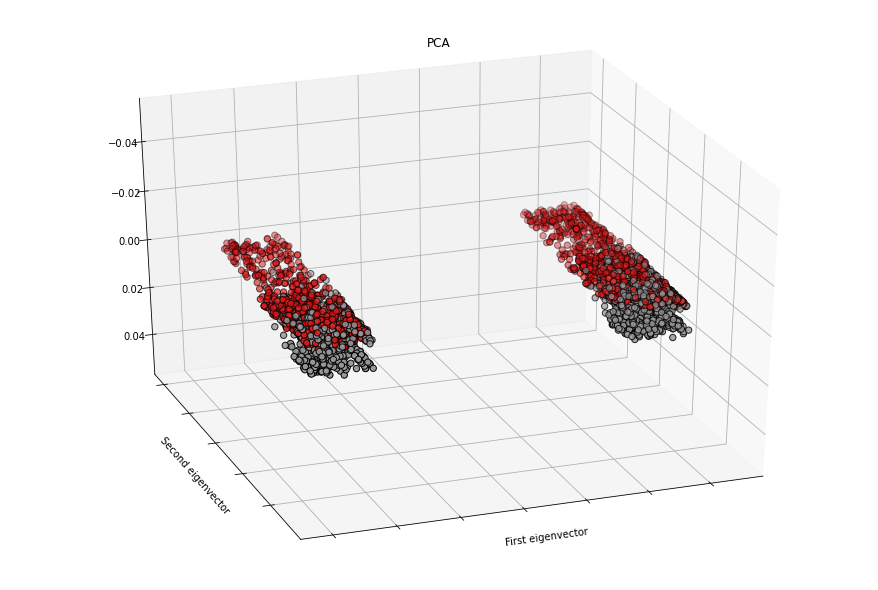

Best validation: 0.819658 using {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Test score: 0.790310


In [ ]:
pca = PCA(n_components=2)
pca_dataset = pca.fit_transform(dropped)
inverse_pca_dataset = pca.inverse_transform(pca_dataset)

MSE_score = ((dropped - inverse_pca_dataset)**2).sum(axis=1)

dorp_num = 0

MSE_max_scores = MSE_score.nlargest(dorp_num).index

dropped_dataset = x_train.drop(MSE_max_scores, axis=0)
dropped_dataset_labels = y_train.drop(MSE_max_scores, axis=0)

print(len(dropped_dataset))

fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=2).fit_transform(dropped_dataset)
ax.scatter(X_reduced[:, 0], 
          X_reduced[:, 1], 
          c=dropped_dataset_labels,
          cmap=plt.cm.Set1, 
          edgecolor='k', 
           s=40)
ax.set_title("PCA")
ax.set_xlabel("First eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("Second eigenvector")
ax.w_yaxis.set_ticklabels([])

plt.show()

model = LogisticRegression(max_iter=200)
solvers = ['lbfgs']
penalty = ['l2']
c_values = [10]

grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=5, 
                           scoring='accuracy',
                           error_score=0)
grid_result = grid_search.fit(dropped_dataset, dropped_dataset_labels)

print("Best validation: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Test score: %f" % metrics.accuracy_score(grid_result.best_estimator_.predict(dropped), droppedy))

/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [ ]:
for attribute in primary_attributes:
#  dataset.boxplot(column=attribute, by='target')
  plt.show()

In [ ]:
for attribute in primary_attributes:
  #print("{}: 30 samples example\nglobl mean: {}, global variance:{}".format(attribute, dataset.loc[:,attribute].mean(), dataset.loc[:,attribute].var()))
  dataset[attribute].head(30).plot(kind='bar')
  plt.show()

In [ ]:
#TODO: da printare su uno stesso grafico in colori diversi su base target
'''
for attribute in dataset.columns.values:
  print(attribute + ":")
  dataset.plot(kind='scatter',x='id',y=attribute, color='green')
  dataset0.plot(kind='scatter',x='id',y=attribute, color='blue')
  dataset1.plot(kind='scatter',x='id',y=attribute, color='red')
  plt.show()
'''
#for attribute in dataset.columns.values:
 # dataset.plot(kind='scatter', x='target',y=attribute)

'\nfor attribute in dataset.columns.values:\n  print(attribute + ":")\n  dataset.plot(kind=\'scatter\',x=\'id\',y=attribute, color=\'green\')\n  dataset0.plot(kind=\'scatter\',x=\'id\',y=attribute, color=\'blue\')\n  dataset1.plot(kind=\'scatter\',x=\'id\',y=attribute, color=\'red\')\n  plt.show()\n'

CLASSIFICAZIONE

- Logistic regression

- KNN

- Gaussian Naive Bayes

- Random Forest

- Support Vector Machine  (sia soft sia rbf)

- PCA

grid search cross-validation per hyperparametri perogni

20% test 
80% train cross valid

precision 
roc 
auc 

#ANALISI

- curva di apprendimento

- matrice di confusione

- accuracy
 
- recall